# Prediction <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Background

stuff

## Description
This notebook

### Load Packages

In [ ]:
# !pip install richdem

In [1]:
import datacube
from odc.algo import xr_geomedian, int_geomedian
import xarray as xr
import subprocess as sp
import numpy as np
from joblib import load
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
import matplotlib.pyplot as plt
# import richdem as rd

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_classificationtools import predict_xr ,predict_proba_xr, HiddenPrints
from deafrica_dask import create_local_dask_cluster
from deafrica_plotting import map_shapefile, rgb
from deafrica_bandindices import calculate_indices
# from deafrica_temporal_statistics import temporal_statistics

import warnings
warnings.filterwarnings("ignore")

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46007 Dashboard: /user/chad/proxy/46479/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

* `ncpus`: Set this value to > 1 to parallelize the collection of training data. eg. npus=8. 
* `model`: Set

In [3]:
# automatically detect number of cpus, adjust to [-3:] if working on deafault Sandbox
ncpus= int(float(sp.getoutput('env | grep CPU')[-4:]))

model_path = 'results/ml_model.joblib'

print('ncpus = '+str(ncpus))

ncpus = 15


### Connect to the datacube

In [4]:
dc = datacube.Datacube(app='prediction')

## Open the model



In [5]:
model = load(model_path)

## Some test locations

In [6]:
locations = {'1':(12.2636, 37.0244),
             '2':(-0.2953, 38.4422),
             '3':(11.5217, 37.4894),
#              '4':(-0.6294, 34.1357),
             '5':(-0.3878, 37.4869),
             '6':(-3.4866, 37.3650),
             '7':(-0.7062, 36.5865),
             '8':(-0.6926, 35.6443)
            }

buffer = 0.25

## Make a prediction

Extract data from the datacube exactly matching the feature layers we created during the extraction of training data in script `1_Extract_training_data.ipynb`

### Redefine the feature layer function

In [7]:
from xr_geomedian_tmad import xr_geomedian_tmad

def two_seasons_gm_mads(ds):
    
    ds = ds / 10000
    ds1 = ds.sel(time=slice('2019-01', '2019-06'))
    ds2 = ds.sel(time=slice('2019-07', '2019-12')) 
    
    def fun(ds, era):
        
        #band indices
        with HiddenPrints():
            bi = calculate_indices(ds,
                               index=['EVI', 'LAI'],
                               drop=True,
                               normalise=False,
                               collection='s2')
        
        bi_max = bi.max('time')
        bi_min = bi.min('time')
        bi_range = bi_max - bi_min
        bi_range = bi_range.rename({'EVI':'EVI_range','LAI':'LAI_range'})
        bi_max = bi_max.rename({'EVI':'EVI_max','LAI':'LAI_max'})
        bi_min = bi_min.rename({'EVI':'EVI_min','LAI':'LAI_min'})
        
        #geomedian and tmads
        gm_mads = xr_geomedian_tmad(ds)
        
        with HiddenPrints():
            gm_mads = calculate_indices(gm_mads,
                               index=['EVI', 'LAI'],
                               drop=False,
                               normalise=False,
                               collection='s2')
        
        gm_mads['edev'] = -np.log(gm_mads['edev'])
        gm_mads['sdev'] = -np.log(gm_mads['sdev'])
        gm_mads['bcdev'] = -np.log(gm_mads['bcdev'])
        
        out = xr.merge([gm_mads,bi_max,bi_min,bi_range],compat='override')
        
        for band in out.data_vars:
            out = out.rename({band:band+era})
        
        return out
    
    epoch1 = fun(ds1, era='_S1')
    epoch2 = fun(ds2, era='_S2')
    
    result = xr.merge([epoch1,
                       epoch2],
                      compat='override')

    return result.squeeze()

### Set up datacube query

In [8]:
#set up our inputs to collect_training_data
products =  ['s2_l2a']
time = ('2019-01','2019-12')

# Set up the inputs for the ODC query
measurements =  ['red', 'green', 'nir', 'blue', 'swir_1', 'swir_2']
resolution = (-20,20)
output_crs='epsg:6933'
dask_chunks={'x':1000,'y':1000,'time':-1}

### Loop through locations and predict

In [9]:
predictions = []
prediction_proba = []
features = []
# for index, row in gdf.iloc[list_of_tiles].iterrows():
for key, latlon in locations.items():
    print("Working on : "+str(latlon))
    
    # generate a datacube query object
    query = {
        'x': (latlon[1]-buffer, latlon[1]+buffer),
        'y': (latlon[0]+buffer, latlon[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    with HiddenPrints():
        ds = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      min_gooddata=0.15,
                      **query)
    
    data = two_seasons_gm_mads(ds)
    data = data.compute()
    
    #predict using the imported model
    print('   predicting...')
    predicted = predict_xr(model, data, progress=True)
    probability = predict_proba_xr(model, data.squeeze(), progress=True)
    predictions.append(predicted)
    prediction_proba.append(probability)
    features.append(data)
    
    write_cog(predicted, 'results/classifications/Eastern_tile'+key+'_prediction.tif', overwrite=True)
    write_cog(probability, 'results/classifications/Eastern_tile'+key+'_probability.tif', overwrite=True)


Working on : (12.2636, 37.0244)
   predicting...
Working on : (-0.2953, 38.4422)
   predicting...
Working on : (11.5217, 37.4894)
   predicting...
Working on : (-0.3878, 37.4869)
   predicting...
Working on : (-3.4866, 37.365)
   predicting...
Working on : (-0.7062, 36.5865)
   predicting...
Working on : (-0.6926, 35.6443)
   predicting...


### Plotting

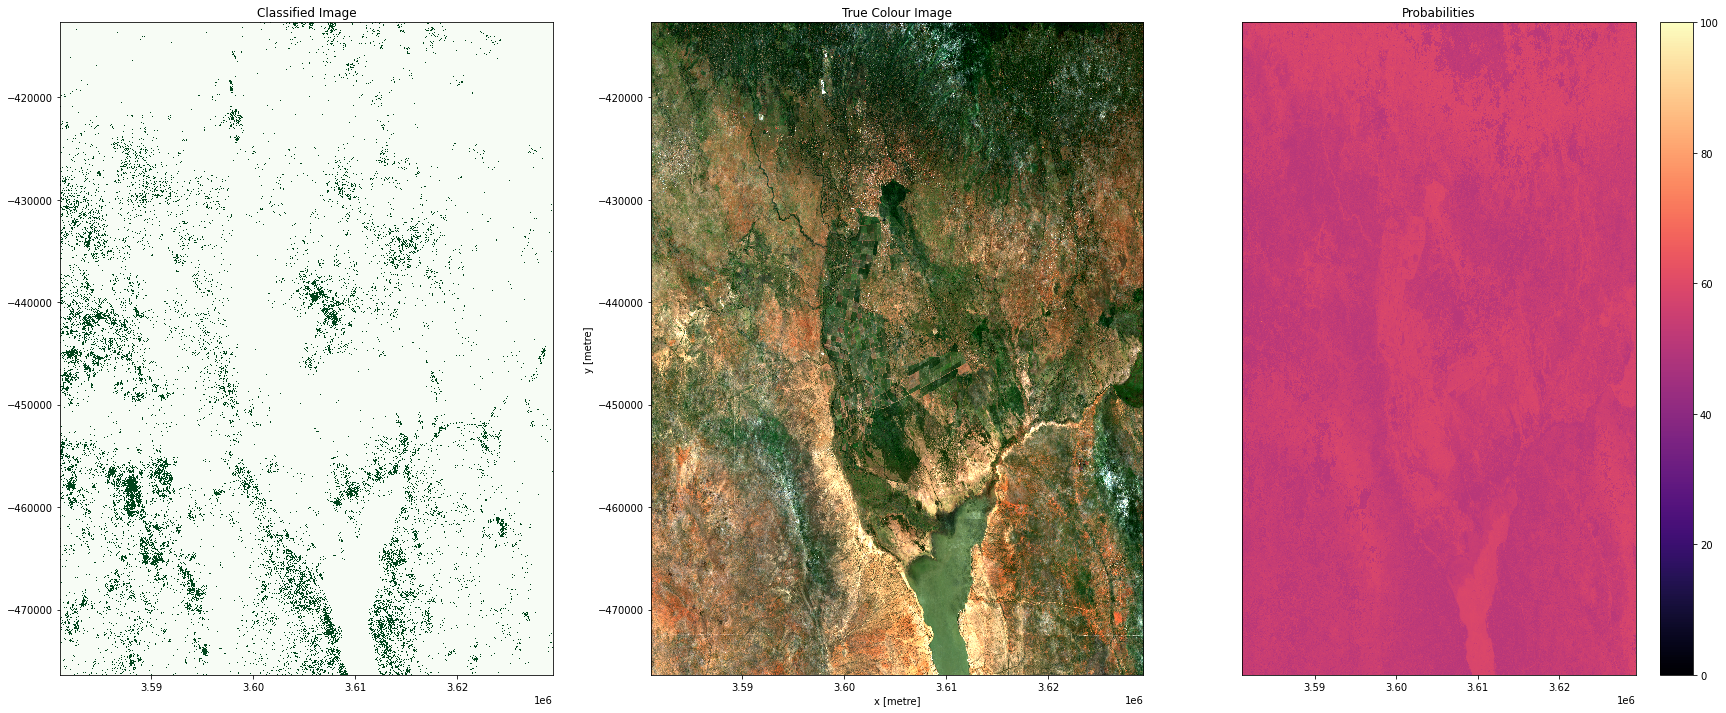

In [19]:
idx=4

fig, axes = plt.subplots(1, 3, figsize=(30, 12))

# Plot classified image
predictions[idx].plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(features[idx], bands=['red_S2','green_S2','blue_S2'],
    ax=axes[1], percentile_stretch=(0.01, 0.99))

prediction_proba[idx].plot(ax=axes[2], 
               cmap='magma',
               vmin=0,
               vmax=100,
               add_labels=False, 
               add_colorbar=True)

# Remove axis on right plot
axes[2].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('True Colour Image')
axes[2].set_title('Probabilities');